In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [132]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [232]:
# build the dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [20]:
C = torch.randn((27, 2))

In [38]:
# pytorch indexing is awesome
# we just have to do C[X]
# C[X].shape -> [32, 3, 2]
# X[13, 2] -> 1
# C[X][13, 2] -> some embedding A
# C[1] -> same embedding A

In [40]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [41]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [54]:
# method 1: torch.cat([emb[:, 0], emb[:, 1], emb[:, 2]], dim=1)
# method 2: torch.cat(torch.unbind(emb, 1), 1)

In [76]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [79]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [98]:
logits = h @ W2 + b2
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

In [90]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(17.4628)

In [91]:
# ------- now made more respectable -------------

In [261]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182437, 3]), torch.Size([182437]))

In [318]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [319]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [320]:
for p in parameters:
    p.requires_grad = True

In [321]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [322]:
lri = []
lossi = []
stepi = []

In [323]:
for i in range(200000):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

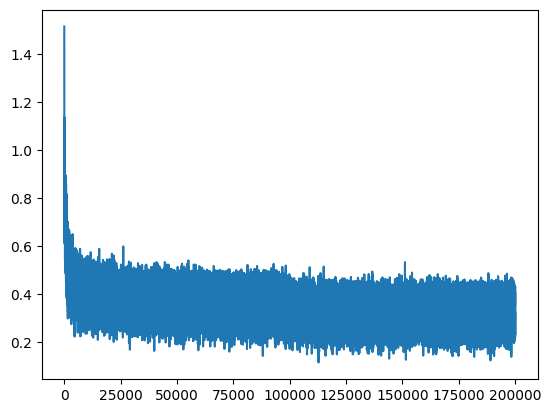

In [324]:
plt.plot(torch.arange(len(lossi)), lossi)

In [325]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1173, grad_fn=<NllLossBackward0>)

In [326]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1791, grad_fn=<NllLossBackward0>)

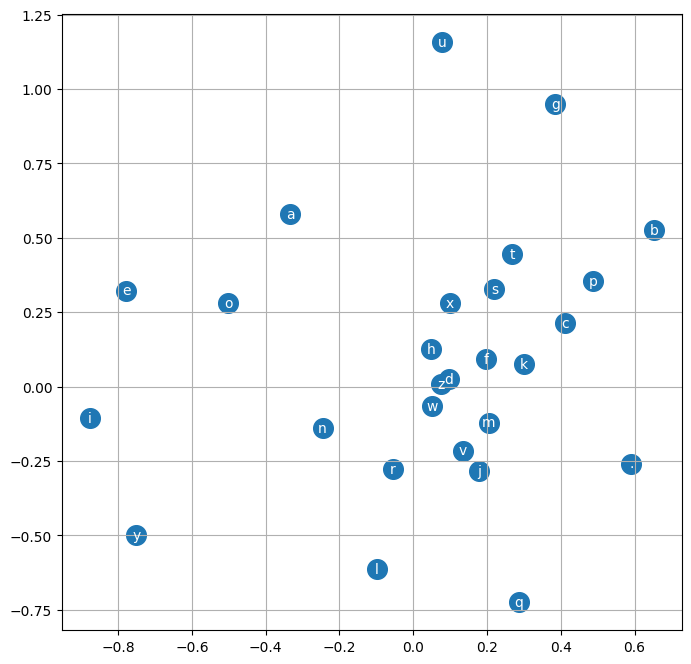

In [291]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

In [ ]:
# training split, dev/validation split, test split
# 80%, 

In [330]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...

    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d) you need this size to do the matrix multiplication on the next step
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]

        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmahzamille.
khaimli.
reh.
cassanden.
jazhnen.
den.
rha.
kaqhil.
ramari.
chaihvik.
leggy.
ham.
joce.
quinn.
sulin.
alianni.
wajean.
dearinix.
kaellinsley.
daya.
